# Intsall Package

In [ ]:
# Install relevant packages, if not yet
!pip3 install awswrangler
!pip3 install pandasql
!pip3 install -U nltk
!pip3 install gensim
!pip3 install -U pip setuptools wheel
!pip3 install -U spacy
!python -m spacy download en_core_web_sm

# Import Packages and Connect to RedShift

In [3]:
from data_connector import *
import numpy as np
import pandas as pd

In [4]:
# Fill in the relevant credentials for Redshift cluster(s) and S3 bucket(s) to use
role_arn = 'arn:aws:iam::848271137894:role/RedShiftAccessFromSageMakerAccount'
role_session_name = 'AssumeRoleSession1'
secret_name = 'arn:aws:secretsmanager:us-west-2:848271137894:secret:Redshift-DLL-Sagemaker-Secret-nHWV37'
dbname = 'ucicanvas'
region_name = 'us-west-2'
bucket_name = 'uci-dll-mellon-redshift-unload-us-west-2'
unload_iam_role = 'arn:aws:iam::848271137894:role/uci-write-to-dll-mellon-redshift-unload-s3-bucket-role,arn:aws:iam::686457044982:role/uci-oit-dwh-redshift-to-mellon-s3-unload-role'

In [5]:
# Initiate a connector object
redshift_s3_connect = RedshiftS3Connector(role_arn, role_session_name, secret_name, dbname, bucket_name, region_name, unload_iam_role)

# 1. Get the mellon_layer2.discussion_post table from Fall 2020 to Spring 2022

In [40]:
query = f'''SELECT * FROM mellon_layer2.student;'''

In [41]:
file_in_s3 = 'temp_0.csv'
redshift_s3_connect.unload_from_redshift_to_s3(query, file_in_s3, 'csv')

Done waiting to finish Data API.
Status: FINISHED. Excution time: 1979 miliseconds
{'ClusterIdentifier': 'uci-datalake-canvas-cluster-v1-redshiftcluster-a9h29wndif8j', 'CreatedAt': datetime.datetime(2022, 7, 29, 7, 21, 44, 611000, tzinfo=tzlocal()), 'Duration': 1979476451, 'HasResultSet': False, 'Id': 'b2c3a72e-83ef-4017-9e85-00072c8f32c7', 'QueryString': "UNLOAD ('SELECT * FROM mellon_layer2.student') TO 's3://uci-dll-mellon-redshift-unload-us-west-2/temp_0.csv' IAM_ROLE '' ALLOWOVERWRITE HEADER ENCRYPTED AUTO FORMAT CSV;", 'RedshiftPid': 1074377652, 'RedshiftQueryId': 4806878, 'ResultRows': 0, 'ResultSize': 0, 'SecretArn': 'arn:aws:secretsmanager:us-west-2:848271137894:secret:Redshift-DLL-Sagemaker-Secret-nHWV37', 'Status': 'FINISHED', 'UpdatedAt': datetime.datetime(2022, 7, 29, 7, 21, 47, 90000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '42e58a37-5994-4f55-a8fc-6fa65df05d1b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '42e58a37-5994-4f55-a8fc-6fa65df05d1b'

In [42]:
file_names = [file_in_s3]
file_type = 'csv'
student = redshift_s3_connect.read_from_s3(file_names, file_type)
student

/opt/conda/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (3,5,43) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)
/opt/conda/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (3,5,163) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)
/opt/conda/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)
/opt/conda/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (166) have mixed types.Specify dtype option on import or set low_memory=False.
  result = self.fn(*self.args, **self.kwargs)
/opt/conda/lib/python3.7/concurrent/futures/thread.py:57: DtypeWarning: Columns (3,5,43,68,163) have mixed types.Specify dtype option on import or set low_memory=False.
  resu

,student_sid,mellon_id,group_a,mellon_enr_dt_a,group_b,mellon_enr_dt_b,birth_year,birth_month,gender,int_student,...,grad_major_3_desc,female,asian,hispanic,black,white,cohort,parent_educ,urm,mellon_yr
0,12893007,253620,no,NaN,no,NaN,1983.0,1.0,F,0.0,...,NaN,yes,no,no,no,yes,2001.0,7.0,0.0,NaN
1,12893018,261464,no,NaN,no,NaN,1985.0,12.0,M,0.0,...,NaN,no,no,no,no,yes,2004.0,7.0,0.0,NaN
2,12909001,235904,no,NaN,no,NaN,1985.0,4.0,M,0.0,...,NaN,no,no,no,no,no,2003.0,NaN,1.0,NaN
3,12909002,6087595,NaN,NaN,NaN,NaN,1997.0,12.0,M,0.0,...,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12909004,6136806,NaN,NaN,NaN,NaN,2003.0,7.0,F,0.0,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138631,6805711,421975,no,NaN,no,NaN,1991.0,6.0,F,0.0,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138632,6805728,2931247,no,NaN,no,NaN,1999.0,5.0,F,1.0,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138633,6805826,428710,no,NaN,no,NaN,1999.0,3.0,M,0.0,...,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138634,6805836,402299,no,NaN,no,NaN,1989.0,3.0,F,0.0,...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
get_df_query = f'''
WITH roster AS
         (SELECT DISTINCT mellon_id,
                          sis_term_code,
                          instruc_begins::DATE,
                          (instruc_ends::DATE + 9) AS final_ends,
                          canvas_course_id,
                          sis_course_code
          FROM mellon_layer2.enrollment er
                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc
          WHERE is_valid_user
            AND is_valid_course_section
            AND enrollment_type = \\'StudentEnrollment\\')
SELECT dp.*, rs.sis_term_code AS term, st.citizenship_app AS citizenship
FROM mellon_layer2.v_discussion_post AS dp 
INNER JOIN roster rs
                ON dp.canvas_course_id = rs.canvas_course_id AND dp.mellon_id = rs.mellon_id
INNER JOIN mellon_layer2.student st 
                ON dp.mellon_id = st.mellon_id
WHERE CONVERT_TIMEZONE(\\'PST\\', dp.discussion_post_created_at) BETWEEN \\'2020-10-01 00:00:00\\' AND \\'2022-06-10 00:00:00\\' 
AND CONVERT_TIMEZONE(\\'PST\\', dp.discussion_post_created_at) BETWEEN rs.instruc_begins AND rs.final_ends
AND dp.discussion_post_deleted_at IS NULL;'''
print(get_df_query)


WITH roster AS
         (SELECT DISTINCT mellon_id,
                          sis_term_code,
                          instruc_begins::DATE,
                          (instruc_ends::DATE + 9) AS final_ends,
                          canvas_course_id,
                          sis_course_code
          FROM mellon_layer2.enrollment er
                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc
          WHERE is_valid_user
            AND is_valid_course_section
            AND enrollment_type = \'StudentEnrollment\')
SELECT dp.*, rs.sis_term_code AS term, st.citizenship_app AS citizenship
FROM mellon_layer2.v_discussion_post AS dp 
INNER JOIN roster rs
                ON dp.canvas_course_id = rs.canvas_course_id AND dp.mellon_id = rs.mellon_id
INNER JOIN mellon_layer2.student st 
                ON dp.mellon_id = st.mellon_id
WHERE CONVERT_TIMEZONE(\'PST\', dp.discussion_post_created_at) BETWEEN \'2020-10-01 00:00:00\' AND \'2022-06-10 00:00:00\' 
AND C

In [6]:
file_in_s3 = 'discussion_post_2020_2022.csv'

In [10]:
redshift_s3_connect.unload_from_redshift_to_s3(get_df_query, file_in_s3, 'csv')

Waiter DataAPIExecution failed: Max attempts exceeded
Status: STARTED. Excution time: 0 miliseconds
{'ClusterIdentifier': 'uci-datalake-canvas-cluster-v1-redshiftcluster-a9h29wndif8j', 'CreatedAt': datetime.datetime(2022, 8, 11, 23, 16, 19, 755000, tzinfo=tzlocal()), 'Duration': -1, 'HasResultSet': False, 'Id': '9ec1e3fc-150f-423d-a789-0a592e3b47bc', 'QueryString': "UNLOAD ('\nWITH roster AS\n         (SELECT DISTINCT mellon_id,\n                          sis_term_code,\n                          instruc_begins::DATE,\n                          (instruc_ends::DATE + 9) AS final_ends,\n                          canvas_course_id,\n                          sis_course_code\n          FROM mellon_layer2.enrollment er\n                   LEFT JOIN mellon_layer2.term_dates td ON er.sis_term_code = td.term_desc\n          WHERE is_valid_user\n            AND is_valid_course_section\n            AND enrollment_type = \\'StudentEnrollment\\')\nSELECT dp.*, rs.sis_term_code AS term, st.citizensh

In [7]:
file_names = [file_in_s3]
file_type = 'csv'
discussion_post = redshift_s3_connect.read_from_s3(file_names, file_type)
discussion_post

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,discussion_post_updated_at,discussion_post_deleted_at,discussion_post_depth,parent_discussion_post_id,discussion_topic_id,discussion_topic_title,is_announcement,discussion_topic_created_at,discussion_topic_posted_at,discussion_topic_delayed_post_at,discussion_topic_pinned,user_group_id,assignment_id,term,citizenship
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,2022-03-01 07:36:52.865,NaN,1,NaN,679184,Discussion Board #16 - Discussion Board Group 1,NaN,2022-01-10 17:53:50.198,2022-01-10 17:53:50.198,NaN,f,149472.0,881137.0,Winter 2022,US Citizen in Transit
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,2022-03-10 05:06:35.605,NaN,1,NaN,679190,Discussion Board #19 - Discussion Board Group 1,NaN,2022-01-10 17:54:41.292,2022-01-10 17:54:41.293,NaN,f,149472.0,881134.0,Winter 2022,US Citizen in Transit
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,2022-03-03 07:35:35.021,NaN,1,NaN,679186,Discussion Board #17 - Discussion Board Group 1,NaN,2022-01-10 17:54:11.739,2022-01-10 17:54:11.74,NaN,f,149472.0,881136.0,Winter 2022,US Citizen in Transit
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,2022-02-22 07:06:58.18,NaN,1,NaN,679178,Discussion Board #14 - Discussion Board Group 1,NaN,2022-01-10 17:53:18.992,2022-01-10 17:53:18.992,NaN,f,149472.0,881139.0,Winter 2022,US Citizen in Transit
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,2021-01-23 02:45:06.688,NaN,1,NaN,464333,Monopolistic Competition (Graded) - Discussion...,NaN,2020-12-25 01:04:31.718,2020-12-25 01:04:31.72,NaN,f,109579.0,652313.0,Winter 2021,Permanent Resident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,2021-04-17 05:14:42.667,NaN,2,3958952.0,537648,Week 3 Discussion,NaN,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,NaN,f,NaN,740035.0,Spring 2021,US Citizen in Transit
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,2021-04-17 02:40:07.184,NaN,3,3964734.0,537648,Week 3 Discussion,NaN,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,NaN,f,NaN,740035.0,Spring 2021,US Citizen in Transit
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,2021-04-18 22:13:38.639,NaN,3,3967451.0,537648,Week 3 Discussion,NaN,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,NaN,f,NaN,740035.0,Spring 2021,US Citizen in Transit
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,2021-03-30 18:10:15.886,NaN,1,NaN,520693,March 30 (Tuesday) - Learning outcomes #1,NaN,2021-03-18 19:15:34.624,2021-03-23 23:51:26.375,NaN,f,NaN,712812.0,Spring 2021,US Citizen in Transit


In [8]:
df = discussion_post.loc[:, ['discussion_post_id', 'mellon_id', 'canvas_course_id', 'discussion_post_content', 'discussion_post_created_at', 'parent_discussion_post_id', 'discussion_topic_id', 'discussion_topic_created_at', 'discussion_topic_posted_at', 'term', 'citizenship']]
df.loc[df['discussion_topic_posted_at'].isna(), 'discussion_topic_posted_at'] = df.loc[df['discussion_topic_posted_at'].isna(), 'discussion_topic_created_at']

In [10]:
df

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,citizenship
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 17:53:50.198,Winter 2022,US Citizen in Transit
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 17:54:41.293,Winter 2022,US Citizen in Transit
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 17:54:11.74,Winter 2022,US Citizen in Transit
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 17:53:18.992,Winter 2022,US Citizen in Transit
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,NaN,464333,2020-12-25 01:04:31.718,2020-12-25 01:04:31.72,Winter 2021,Permanent Resident
...,...,...,...,...,...,...,...,...,...,...,...
1168339,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-17 05:14:42.667,3958952.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,US Citizen in Transit
1168340,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-17 02:40:07.184,3964734.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,US Citizen in Transit
1168341,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 22:13:38.639,3967451.0,537648,2021-03-30 13:32:43.564,2021-04-11 23:58:50.802,Spring 2021,US Citizen in Transit
1168342,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 18:10:15.886,NaN,520693,2021-03-18 19:15:34.624,2021-03-23 23:51:26.375,Spring 2021,US Citizen in Transit


# 2. Preprocess the data

## 2.1 Clean the data

In [9]:
import online_discourse_analysis as oda
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'gensim'

In [ ]:
df = oda.discussion_text_clean(df)

In [ ]:
df.head(2)

## 2.2 Transfer the UTC timestamp to Pacific timestamp

In [50]:
df = oda.utc_to_pts(df)

In [51]:
df.head(3)

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,citizenship
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,US Citizen in Transit
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,US Citizen in Transit
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,US Citizen in Transit


# 3. Calculate and Standardize Behavioral Features and LIWC Outputs

In [52]:
df = oda.discussion_topic_post_time_gap(df)

In [53]:
df.head()

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_created_at,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 17:53:50.198,2022-01-10 09:53:50.198000-08:00,Winter 2022,US Citizen in Transit,49.571559
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 17:54:41.292,2022-01-10 09:54:41.293000-08:00,Winter 2022,US Citizen in Transit,58.466601
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 17:54:11.739,2022-01-10 09:54:11.740000-08:00,Winter 2022,US Citizen in Transit,51.570408
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 17:53:18.992,2022-01-10 09:53:18.992000-08:00,Winter 2022,US Citizen in Transit,42.551148
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-22 18:45:06.688000-08:00,NaN,464333,2020-12-25 01:04:31.718,2020-12-24 17:04:31.720000-08:00,Winter 2021,Permanent Resident,29.069849


In [15]:
LIWC_file = ['LIWC2015 Results (discussion_post_id_content.csv).csv']
df_LIWC = redshift_s3_connect.read_from_s3(LIWC_file, 'csv')
df_LIWC

/opt/conda/lib/python3.7/site-packages/awswrangler/s3/_read_text.py:156: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  path=paths[0], version_id=version_id[paths[0]] if isinstance(version_id, dict) else version_id, **args


,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,discussion_post_id,discussion_post_content,3,93.26,99.00,98.01,25.77,3.00,66.67,66.67,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,66.67
1,3785584,"<p>Hi Jason,&nbsp;</p>\n<p>It's funny for me, ...",139,19.29,30.73,82.55,98.64,15.44,8.63,92.81,...,2.88,0.00,1.44,0.00,0.00,0.0,0.0,2.16,0.0,9.35
2,3785504,"<p>Hi Nathalie,</p>\n<p>Thanks for sharing. I ...",165,35.74,61.92,73.95,48.24,15.00,9.09,93.33,...,3.64,0.00,0.61,0.00,0.00,0.0,0.0,1.21,0.0,7.27
3,3785553,"<p>Hi Janet,&nbsp;</p>\n<p>I really admire you...",119,29.30,66.29,75.87,99.00,14.88,16.81,88.24,...,5.04,0.00,1.68,0.00,0.84,0.0,0.0,1.68,0.0,10.92
4,3785454,"<p>Hello Catherine,</p>\n<p>I liked how you sa...",178,36.33,38.93,70.08,77.47,17.80,12.92,89.33,...,5.06,0.00,1.12,0.00,0.00,0.0,0.0,2.25,0.0,11.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168340,3863280,"<p>As the Chinese dollar appreciates, Chinese ...",86,93.26,85.24,21.56,69.60,21.50,31.40,80.23,...,3.49,0.00,1.16,0.00,0.00,0.0,0.0,0.00,0.0,6.98
1168341,4119615,<p>3D printing changes supply chain by speedin...,88,77.82,58.97,14.96,25.77,17.60,28.41,71.59,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,5.68
1168342,3900631,<p>Higher interest rates make it more expensiv...,89,89.52,54.48,5.20,25.77,17.80,28.09,85.39,...,2.25,0.00,1.12,0.00,0.00,0.0,0.0,0.00,0.0,6.74
1168343,4077411,<p>The PMI summarizes economic trends in the m...,79,99.00,39.99,61.71,25.77,11.29,29.11,63.29,...,6.33,1.27,0.00,0.00,0.00,0.0,0.0,0.00,0.0,6.33


In [16]:
df_LIWC = df_LIWC.drop(0).rename(columns = {'A':'discussion_post_id','B':'discussion_post_content'})

In [17]:
df_LIWC = df_LIWC.loc[:, ['discussion_post_id', 'Analytic', 'Tone', 'cogproc']]

In [18]:
lst = set(df_LIWC['discussion_post_id'].values)

In [29]:
df[~df['discussion_post_id'].isin(lst)]

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap
911,4257221,203161,36879,<p>Hello! Great job on your poster. One thing ...,2021-06-05 22:37:42.254000-07:00,NaN,572467,2021-06-02 20:55:03.990000-07:00,Spring 2021,US Citizen in Transit,3.071276
912,4257240,203161,36879,<p>Hello! I love the design of your poster and...,2021-06-05 22:48:32.414000-07:00,NaN,572472,2021-06-02 20:57:06.529000-07:00,Spring 2021,US Citizen in Transit,3.077383
913,4257246,203161,36879,"<p>Hello! First off, interesting format that y...",2021-06-05 22:52:55.009000-07:00,NaN,572466,2021-06-02 20:54:15.818000-07:00,Spring 2021,US Citizen in Transit,3.082398
914,4138626,203161,36879,<p>Hello! I find your research topic to be ver...,2021-05-14 15:11:22.091000-07:00,NaN,562329,2021-05-11 13:08:10.338000-07:00,Spring 2021,US Citizen in Transit,3.085553
915,4138686,203161,36879,<p>Hello! I really like your research topic as...,2021-05-14 15:19:15.058000-07:00,NaN,562322,2021-05-11 11:43:23.806000-07:00,Spring 2021,US Citizen in Transit,3.149899
...,...,...,...,...,...,...,...,...,...,...,...
1162590,3106375,201961,30709,"<ul style=""font-size: 14px;""><li>Do you think ...",2020-11-01 17:20:46.404000-08:00,NaN,422227,2020-10-14 20:05:15.184000-07:00,Fall 2020,Not US Citizen,17.927445
1166353,3884296,374004,35258,<p>Hi <span>Ilie. It is quite commendable that...,2021-04-03 21:42:17.192000-07:00,3869958.0,533283,2021-03-28 12:10:21.768000-07:00,Spring 2021,Not US Citizen,6.397169
1166354,3872248,374004,35258,"<p><img src=""/groups/124043/files/13868301/pre...",2021-04-01 21:46:32.596000-07:00,NaN,533283,2021-03-28 12:10:21.768000-07:00,Spring 2021,Not US Citizen,4.400125
1166355,3884273,374004,35258,"<p>Hi, jJaechan. Great post. I agree with you ...",2021-04-03 21:37:45.363000-07:00,3873888.0,533322,2021-03-28 12:32:59.316000-07:00,Spring 2021,Not US Citizen,6.378311


In [24]:
lst1 = set(df['discussion_post_id'].values)

In [25]:
df_LIWC[~df_LIWC['discussion_post_id'].isin(lst1)]

,discussion_post_id,Analytic,Tone,cogproc
1,3785584,19.29,98.64,14.39
2,3785504,35.74,48.24,13.94
3,3785553,29.30,99.00,16.81
4,3785454,36.33,77.47,18.54
5,3785399,42.91,99.00,16.55
...,...,...,...,...
8187,3118622,71.92,54.74,13.85
8188,3118597,56.60,43.65,11.27
8189,3113569,79.93,7.84,14.94
8190,3901710,99.00,25.77,0.00


In [57]:
df = df.merge(df_LIWC, how='inner', on='discussion_post_id')
df

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 09:53:50.198000-08:00,Winter 2022,US Citizen in Transit,49.571559,53.90,51.65,12.67
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 09:54:41.293000-08:00,Winter 2022,US Citizen in Transit,58.466601,33.89,77.59,14.08
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 09:54:11.740000-08:00,Winter 2022,US Citizen in Transit,51.570408,67.40,3.09,11.11
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 09:53:18.992000-08:00,Winter 2022,US Citizen in Transit,42.551148,71.24,82.05,11.40
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-22 18:45:06.688000-08:00,NaN,464333,2020-12-24 17:04:31.720000-08:00,Winter 2021,Permanent Resident,29.069849,89.86,55.05,9.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160148,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-16 22:14:42.667000-07:00,3958952.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,5.219350,85.92,62.94,5.88
1160149,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-16 19:40:07.184000-07:00,3964734.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,5.111995,51.25,73.64,24.36
1160150,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 15:13:38.639000-07:00,3967451.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,6.926943,46.65,25.77,18.58
1160151,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 11:10:15.886000-07:00,NaN,520693,2021-03-23 16:51:26.375000-07:00,Spring 2021,US Citizen in Transit,6.763073,95.35,25.77,5.19


In [58]:
cols = ['discussion_topic_post_time_gap', 'Analytic', 'Tone', 'cogproc']

In [87]:
df_st = oda.standardized_score(df, cols)
df_st

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 09:53:50.198000-08:00,Winter 2022,US Citizen in Transit,0.800000,0.200000,0.600000,0.400000
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 09:54:41.293000-08:00,Winter 2022,US Citizen in Transit,0.375000,0.250000,0.750000,0.750000
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 09:54:11.740000-08:00,Winter 2022,US Citizen in Transit,0.777778,0.333333,0.111111,0.222222
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-21 23:06:58.180000-08:00,NaN,679178,2022-01-10 09:53:18.992000-08:00,Winter 2022,US Citizen in Transit,0.692308,0.615385,0.692308,0.307692
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-22 18:45:06.688000-08:00,NaN,464333,2020-12-24 17:04:31.720000-08:00,Winter 2021,Permanent Resident,0.937500,0.604167,0.291667,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160148,3976802,174455,36826,<p>I loved your presentation! In terms of bupe...,2021-04-16 22:14:42.667000-07:00,3958952.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,0.611511,0.762590,0.374101,0.043165
1160149,3975548,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-16 19:40:07.184000-07:00,3964734.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,0.474820,0.208633,0.446043,1.000000
1160150,3982902,174455,36826,"<p>Hello,</p>\n<p>So the main reason that pati...",2021-04-18 15:13:38.639000-07:00,3967451.0,537648,2021-04-11 16:58:50.802000-07:00,Spring 2021,US Citizen in Transit,0.884892,0.151079,0.165468,0.848921
1160151,3849145,171666,35994,"<p>According to google, the Universe is 13.8 b...",2021-03-30 11:10:15.886000-07:00,NaN,520693,2021-03-23 16:51:26.375000-07:00,Spring 2021,US Citizen in Transit,0.400000,0.666667,0.133333,0.400000


In [60]:
df_foreign = df_st.loc[df['citizenship'] == 'Not US Citizen']
df_US = df_st.loc[df['citizenship'] != 'Not US Citizen']

In [21]:
df_pc_foreign= oda.discussion_post_count(df_foreign)
df_pc_US = oda.discussion_post_count(df_US)

In [17]:
df_foreign_avg = oda.calculate_features_avg(df_foreign, cols)
df_US_avg = oda.calculate_features_avg(df_US, cols)

In [18]:
df_foreign_avg = df_foreign_avg.merge(df_pc_foreign, how='inner', on='term')
df_US_avg = df_US_avg.merge(df_pc_US, how='inner', on='term')

In [23]:
term_order = ['Fall 2020', 'Winter 2021', 'Spring 2021', 'Fall 2021', 'Winter 2022', 'Spring 2022']

In [20]:
df_foreign_avg = df_foreign_avg.set_index('term').loc[term_order].reset_index()
df_US_avg = df_US_avg.set_index('term').loc[term_order].reset_index()

In [21]:
df_US_avg

,term,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,health_avg,discussion_post_cnt_avg
0,Fall 2020,17.520545,67.620665,56.684655,11.249382,0.576671,10.555474
1,Winter 2021,15.401733,68.041776,57.848818,11.676780,0.649961,11.400441
2,Spring 2021,16.528965,68.230013,58.778378,11.865248,0.653548,11.875506
3,Fall 2021,18.692554,70.085483,56.288113,11.207892,0.678522,10.810694
4,Winter 2022,15.952904,69.608439,57.303984,11.546663,0.571578,11.261329
5,Spring 2022,17.504702,69.789106,59.231836,11.144971,0.557109,10.571951


In [22]:
df_foreign_avg

,term,discussion_topic_post_time_gap_avg,Analytic_avg,Tone_avg,cogproc_avg,health_avg,discussion_post_cnt_avg
0,Fall 2020,16.935294,68.688480,55.168751,11.158574,0.491750,11.516620
1,Winter 2021,14.573272,71.394187,55.346371,11.369843,0.493823,11.573187
2,Spring 2021,14.810537,72.447879,55.772503,11.200696,0.560378,10.927162
3,Fall 2021,18.825772,73.079557,56.552858,11.628109,0.562089,11.559211
4,Winter 2022,16.312214,74.525233,55.689875,11.331930,0.482522,11.213053
5,Spring 2022,16.389752,72.777712,56.391135,11.132070,0.460331,10.368386


# Trend of variables

In [23]:
import matplotlib.pyplot as plt

In [40]:
# Trend for discussion_topic_post_time_gap_avg
plt.ylim(0, 25)
plt.plot(df_US_avg['term'], df_US_avg['discussion_topic_post_time_gap_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['discussion_topic_post_time_gap_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('Time Gap')
plt.title('Time trend for time gap between \ndiscussion topic posted time and discussion post created time')
plt.legend()

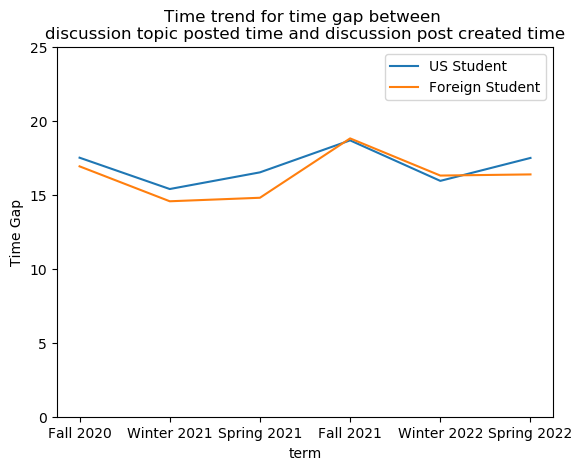

In [41]:
plt.show()

In [47]:
# Trend for Analytic_avg
plt.ylim(40, 85)
plt.plot(df_US_avg['term'], df_US_avg['Analytic_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['Analytic_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('Analytical Thinking')
plt.title('Time trend for analytical thinking')
plt.legend()

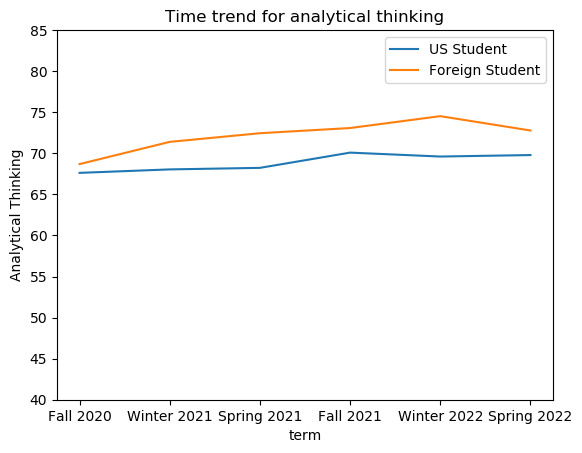

In [48]:
plt.show()

In [61]:
# Trend for Tone_avg
plt.ylim(30, 75)
plt.plot(df_US_avg['term'], df_US_avg['Tone_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['Tone_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('Emotional Tone')
plt.title('Time trend for emotional tone')
plt.legend()

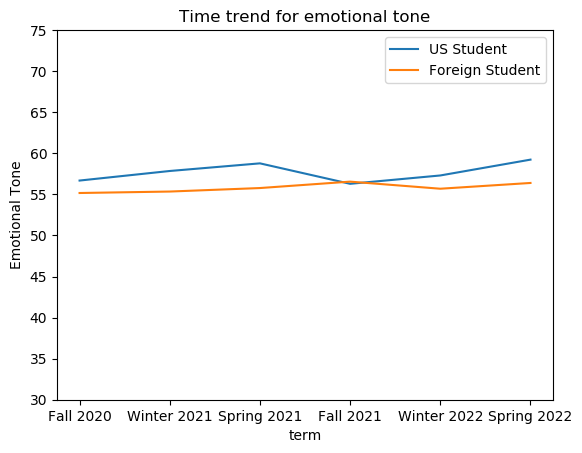

In [62]:
plt.show()

In [69]:
# Trend for cogproc_avg
plt.ylim(0, 14)
plt.plot(df_US_avg['term'], df_US_avg['cogproc_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['cogproc_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('Cognitive Process')
plt.title('Time trend for cognitive process')
plt.legend()

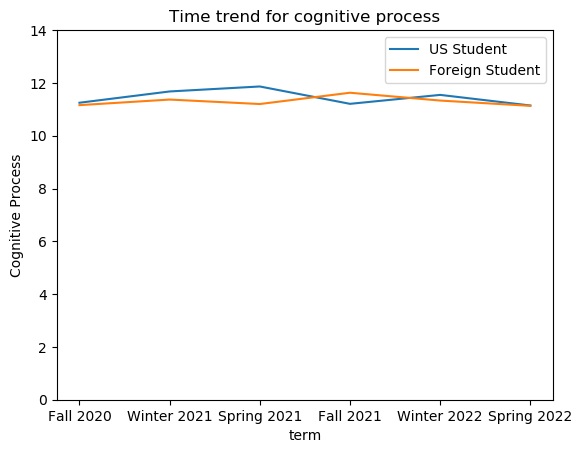

In [70]:
plt.show()

In [71]:
# Trend for health_avg
plt.ylim(0, 1)
plt.plot(df_US_avg['term'], df_US_avg['health_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['health_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('Health Discussion')
plt.title('Time trend for health discussion')
plt.legend()

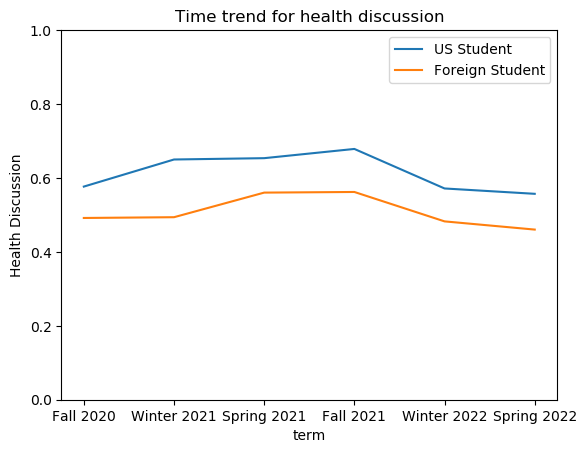

In [72]:
plt.show()

In [75]:
# Trend for discussion_post_cnt_avg
plt.ylim(0, 15)
plt.plot(df_US_avg['term'], df_US_avg['discussion_post_cnt_avg'], label='US Student')
plt.plot(df_foreign_avg['term'], df_foreign_avg['discussion_post_cnt_avg'], label='Foreign Student')
plt.xlabel('term')
plt.ylabel('discussion post count')
plt.title('Time trend for the average number of discussion posts')
plt.legend()

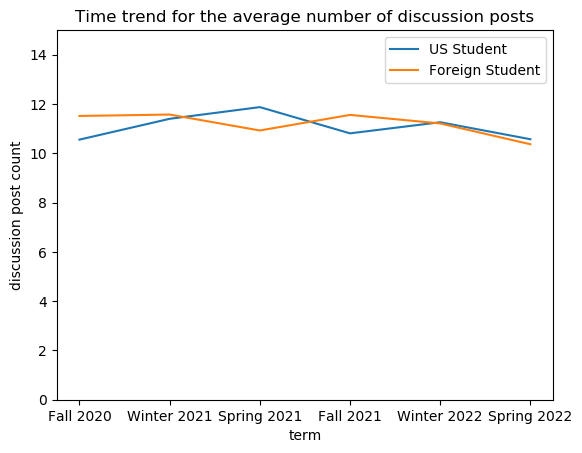

In [76]:
plt.show()

# Trend and Difference

In [17]:
!pip3 install --upgrade scipy


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [18]:
df_US.head(3)

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc,health
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-02-28 23:36:52.865000-08:00,NaN,679184,2022-01-10 09:53:50.198000-08:00,Winter 2022,US Citizen in Transit,0.800000,0.200000,0.600000,0.400000,0.200000
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-09 21:06:35.605000-08:00,NaN,679190,2022-01-10 09:54:41.293000-08:00,Winter 2022,US Citizen in Transit,0.375000,0.250000,0.750000,0.750000,1.000000
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-02 23:35:35.021000-08:00,NaN,679186,2022-01-10 09:54:11.740000-08:00,Winter 2022,US Citizen in Transit,0.777778,0.333333,0.111111,0.222222,0.111111


In [28]:
df_foreign.head(3)

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc,health
306,4730195,185306,40534,<p>Student loans are a huge debt for young Ame...,2021-11-17 19:02:02.528000-08:00,NaN,610641,NaT,Fall 2021,Not US Citizen,NaN,1.0,1.0,1.0,1.0
307,4477708,185306,40534,<p><strong>Millennials dominate the US workfor...,2021-10-05 01:20:47.605000-07:00,NaN,610640,NaT,Fall 2021,Not US Citizen,NaN,1.0,1.0,1.0,1.0
308,4785005,185306,40534,<p>https://canvas.eee.uci.edu/eportfolios/9076...,2021-11-29 17:17:43.046000-08:00,NaN,610642,NaT,Fall 2021,Not US Citizen,NaN,0.5,0.5,0.5,0.5


In [20]:
df_US_pc = df_US.groupby(by=['term', 'mellon_id', 'canvas_course_id'])['discussion_post_id'].count().reset_index(name='discussion_post_cnt')
df_foreign_pc = df_foreign.groupby(by=['term', 'mellon_id', 'canvas_course_id'])['discussion_post_id'].count().reset_index(name='discussion_post_cnt')

In [21]:
df_US_pc

,term,mellon_id,canvas_course_id,discussion_post_cnt
0,Fall 2020,162766,29291,20
1,Fall 2020,162766,30152,1
2,Fall 2020,162766,30507,13
3,Fall 2020,162766,31325,4
4,Fall 2020,162766,31360,3
...,...,...,...,...
86191,Winter 2022,427731,42524,34
86192,Winter 2022,428703,42175,13
86193,Winter 2022,428703,42591,4
86194,Winter 2022,428917,43127,6


In [31]:
df_foreign_pc

,term,mellon_id,canvas_course_id,discussion_post_cnt
0,Fall 2020,162769,28815,7
1,Fall 2020,162801,27521,14
2,Fall 2020,162813,27743,17
3,Fall 2020,162813,30792,22
4,Fall 2020,162832,27873,8
...,...,...,...,...
17854,Winter 2022,427188,42104,1
17855,Winter 2022,427188,42110,14
17856,Winter 2022,428114,41932,2
17857,Winter 2022,430426,43531,4


## GLS for Trend

In [ ]:
import statsmodels.api as sm

In [ ]:
df_US['term_code'] = df_US.apply(lambda row: oda.term_code(row), axis=1)
df_foreign = df_foreign.apply(lambda row: oda.term_code(row), axis=1)

In [ ]:
cols.append('discussion_post_cnt')

In [30]:
clst = ['US Students', 'Foreign Students']
for i, d in enumerate([df_US, df_foreign]):
    print(f'GLS for trend of {clst[i]}:')

    for col in cols:
        print('    ' + col + ':')
        if col == 'discussion_post_cnt':
            if i == 0:
                x = df_US_pc['term_code']
                y = df_US_pc['discussion_post_cnt']
            else:
                x = df_foreign_pc['term_code']
                y = df_foreign_pc['discussion_post_cnt']
        else:
            x = d['term_code']
            y = d[col]

        model = sm.GLS(y, x)
        print('     ', model.summary())
        print()

t-test for trend of US Students:
  Fall 2020 - Winter 2021
    discussion_topic_post_time_gap:
      Ttest_indResult(statistic=nan, pvalue=nan)

    Analytic:
      Ttest_indResult(statistic=-3.7401886666278363, pvalue=0.000183904151981664)

    Tone:
      Ttest_indResult(statistic=-6.084096286874941, pvalue=1.1724080177148078e-09)

    cogproc:
      Ttest_indResult(statistic=-6.924740317841918, pvalue=4.37336544317118e-12)

    health:
      Ttest_indResult(statistic=-4.249070779886787, pvalue=2.1470065036348478e-05)

    discussion_post_cnt:
      Ttest_indResult(statistic=-0.24600583515129917, pvalue=0.8056836693688388)

  Winter 2021 - Spring 2021
    discussion_topic_post_time_gap:
      Ttest_indResult(statistic=nan, pvalue=nan)

    Analytic:
      Ttest_indResult(statistic=-3.943504975465751, pvalue=8.03119383382245e-05)

    Tone:
      Ttest_indResult(statistic=-1.1004071847518706, pvalue=0.2711553606648786)

    cogproc:
      Ttest_indResult(statistic=-7.19207184798367, p

## t-test for Fall 2020

In [24]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Fall 2020', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(t_test_output('Fall 2020', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-17.936316745115274, pvalue=6.698672395612601e-72)

t-test for Tone:
Ttest_indResult(statistic=5.490363403302296, pvalue=4.0143316589214024e-08)

t-test for cogproc:
Ttest_indResult(statistic=8.822537155040068, pvalue=1.1247914142804388e-18)

t-test for health:
Ttest_indResult(statistic=8.931234355995148, pvalue=4.235899695357951e-19)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=-5.992497948535888, pvalue=2.0918054820881734e-09)


In [13]:
lst = set(discussion_post[discussion_post['discussion_topic_posted_at'].isna()]['discussion_topic_id'].values)

In [16]:
lst = tuple(lst)

In [24]:
temp=discussion_post[discussion_post['discussion_topic_id'].isin(lst)].groupby(by='discussion_topic_id')['discussion_post_id'].count().reset_index(name='post_cnt')

In [28]:
temp[temp['post_cnt']==1475]

,discussion_topic_id,post_cnt
2546,498546,1475


In [30]:
dm[dm['canvas_id']==498546]

,id,canvas_id,title,message,type,workflow_state,last_reply_at,created_at,updated_at,delayed_post_at,posted_at,deleted_at,discussion_type,pinned,locked,course_id,group_id
469,44070000000498546,498546,Discussion - Week 1,<p><span>Discussions are a place for students ...,NaN,active,2021-04-04 05:55:25.43,2021-02-09 21:20:03.599,2021-04-04 05:55:26.099,NaN,NaN,NaN,threaded,false,false,44070000000034892,NaN


In [34]:
discussion_post[~discussion_post['discussion_topic_id'].isna()].head()

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,discussion_post_updated_at,discussion_post_deleted_at,discussion_post_depth,parent_discussion_post_id,discussion_topic_id,discussion_topic_title,is_announcement,discussion_topic_created_at,discussion_topic_posted_at,discussion_topic_delayed_post_at,discussion_topic_pinned,user_group_id,assignment_id,term,citizenship
0,5127365,185484,43009,<p>I found the reading for this week's discuss...,2022-03-01 07:36:52.865,2022-03-01 07:36:52.865,NaN,1,NaN,679184,Discussion Board #16 - Discussion Board Group 1,NaN,2022-01-10 17:53:50.198,2022-01-10 17:53:50.198,NaN,f,149472.0,881137.0,Winter 2022,US Citizen in Transit
1,5165138,185484,43009,<p>This week's reading from Florez discusses w...,2022-03-10 05:06:35.605,2022-03-10 05:06:35.605,NaN,1,NaN,679190,Discussion Board #19 - Discussion Board Group 1,NaN,2022-01-10 17:54:41.292,2022-01-10 17:54:41.293,NaN,f,149472.0,881134.0,Winter 2022,US Citizen in Transit
2,5135831,185484,43009,<p>Gilliam's reading for this week placed an e...,2022-03-03 07:35:35.021,2022-03-03 07:35:35.021,NaN,1,NaN,679186,Discussion Board #17 - Discussion Board Group 1,NaN,2022-01-10 17:54:11.739,2022-01-10 17:54:11.74,NaN,f,149472.0,881136.0,Winter 2022,US Citizen in Transit
3,5094972,185484,43009,<p>I found De Sousa's reading very impactful a...,2022-02-22 07:06:58.18,2022-02-22 07:06:58.18,NaN,1,NaN,679178,Discussion Board #14 - Discussion Board Group 1,NaN,2022-01-10 17:53:18.992,2022-01-10 17:53:18.992,NaN,f,149472.0,881139.0,Winter 2022,US Citizen in Transit
4,3522782,172918,32176,"<article class=""discussion_entry can_be_marked...",2021-01-23 02:45:06.688,2021-01-23 02:45:06.688,NaN,1,NaN,464333,Monopolistic Competition (Graded) - Discussion...,NaN,2020-12-25 01:04:31.718,2020-12-25 01:04:31.72,NaN,f,109579.0,652313.0,Winter 2021,Permanent Resident


In [32]:
dm.to_csv('dm.csv')

## t-test for Winter 2021

In [25]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Winter 2021', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(oda.t_test_group('Winter 2021', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-31.195797627901012, pvalue=2.9548218391992878e-213)

t-test for Tone:
Ttest_indResult(statistic=4.44149970524897, pvalue=8.936996265279179e-06)

t-test for cogproc:
Ttest_indResult(statistic=18.89231178141543, pvalue=1.4878508856175312e-79)

t-test for health:
Ttest_indResult(statistic=23.798424861027787, pvalue=4.6890920737897326e-125)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=-0.9023722868064658, pvalue=0.36686846643219595)


## t-test for Spring 2021

In [26]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Spring 2021', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(oda.t_test_group('Spring 2021', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-39.37793318880979, pvalue=0.0)

t-test for Tone:
Ttest_indResult(statistic=16.340775008144796, pvalue=5.438826230234865e-60)

t-test for cogproc:
Ttest_indResult(statistic=26.77046409038226, pvalue=1.1957031401101814e-157)

t-test for health:
Ttest_indResult(statistic=12.033955724385962, pvalue=2.4067847991002472e-33)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=4.777384139761349, pvalue=1.7877636595496573e-06)


## t-test for Fall 2021

In [27]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Fall 2021', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(oda.t_test_group('Fall 2021', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-28.040776214610677, pvalue=1.5558846774107736e-172)

t-test for Tone:
Ttest_indResult(statistic=0.8578048367444883, pvalue=0.39100170433638937)

t-test for cogproc:
Ttest_indResult(statistic=0.15236765061684804, pvalue=0.8788971893762333)

t-test for health:
Ttest_indResult(statistic=12.31258845162085, pvalue=8.077893623728824e-35)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=-3.40688417861263, pvalue=0.0006591125370338077)


## t-test for Winter 2022

In [28]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Winter 2022', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(oda.t_test_group('Winter 2022', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-27.52882990042265, pvalue=2.7378240813407134e-166)

t-test for Tone:
Ttest_indResult(statistic=3.154312140494947, pvalue=0.0016091805576156613)

t-test for cogproc:
Ttest_indResult(statistic=11.777842062098062, pvalue=5.29615781756373e-32)

t-test for health:
Ttest_indResult(statistic=10.648475391507354, pvalue=1.8232195135101173e-26)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=0.17115019735267828, pvalue=0.8641090341881021)


## t-test for Spring 2022

In [29]:
for col in cols:
    print(f't-test for {col}:')
    print(oda.t_test_group('Spring 2022', df_US, df_foreign, col))
    print()
    
print('t-test for discussion_post_cnt:')
print(oda.t_test_group('Spring 2022', df_US_pc, df_foreign_pc, 'discussion_post_cnt'))

t-test for discussion_topic_post_time_gap:
Ttest_indResult(statistic=nan, pvalue=nan)

t-test for Analytic:
Ttest_indResult(statistic=-21.56433380194675, pvalue=7.057191015557672e-103)

t-test for Tone:
Ttest_indResult(statistic=13.318852630768113, pvalue=1.963277823996702e-40)

t-test for cogproc:
Ttest_indResult(statistic=9.094381596762265, pvalue=9.698107312754001e-20)

t-test for health:
Ttest_indResult(statistic=5.87530654734518, pvalue=4.235304255672201e-09)

t-test for discussion_post_cnt:
Ttest_indResult(statistic=0.7436569654731001, pvalue=0.4571043465676431)


# Analyze Reply Rates

In [88]:
df_reply = oda.discussion_reply_rate(df_st)

In [89]:
df_reply

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id_x,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc,parent_discussion_post_id_y,reply_rate
0,3847462,180283,36509,<p>Hey everyone! I'm a 2nd year majoring in Ed...,2021-03-30 00:47:51.502000-07:00,NaN,531000,NaT,Spring 2021,US Citizen in Transit,NaN,0.719577,0.555556,0.492063,3847462.0,1
1,4091662,180283,36509,<p><span>I agree with Veenhoven’s&nbsp;critici...,2021-05-06 19:01:12.473000-07:00,NaN,530971,NaT,Spring 2021,US Citizen in Transit,NaN,0.879032,0.467742,0.838710,4091662.0,1
2,4173140,180283,36509,<p>Although most philosophers did not explicit...,2021-05-20 21:16:13.472000-07:00,NaN,530966,NaT,Spring 2021,US Citizen in Transit,NaN,0.727273,0.504132,0.892562,4173140.0,1
3,3897120,180283,36509,"<p>Hi Babak, this was an interesting take on t...",2021-04-06 02:22:22.314000-07:00,3894065.0,530994,NaT,Spring 2021,US Citizen in Transit,NaN,0.333333,0.271318,0.434109,3897120.0,1
4,4012677,180283,36509,"<p>During the college decision process, some i...",2021-04-22 23:21:50.594000-07:00,NaN,530980,NaT,Spring 2021,US Citizen in Transit,NaN,0.398438,0.546875,0.414062,4012677.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221211,4256072,174455,36826,<p>Wonderful presentation 10B! You mentioned t...,2021-06-05 11:01:23.623000-07:00,4241099.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,0.560150,0.097744,0.503759,0.834586,4256072.0,2
221212,4256059,174455,36826,<p>Great Presentation 10A! In terms of Nirapar...,2021-06-05 10:54:09.952000-07:00,4239356.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,0.552632,0.315789,0.646617,0.609023,4256059.0,1
221213,4256065,174455,36826,"<p>Hey 10C! I loved your presentation, in term...",2021-06-05 10:57:40.544000-07:00,4240938.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,0.556391,0.161654,0.082707,0.199248,4256065.0,1
221214,4170711,174455,36826,<p>Great presentation 8A! I had a question reg...,2021-05-20 15:19:11.965000-07:00,4166130.0,537639,2021-05-17 14:37:34.582000-07:00,Spring 2021,US Citizen in Transit,0.122302,0.366906,0.503597,0.071942,4170711.0,1


## Linear Regression

In [65]:
import statsmodels.api as sm

In [64]:
cols

['discussion_topic_post_time_gap', 'Analytic', 'Tone', 'cogproc']

In [75]:
cols = ['discussion_topic_post_time_gap', 'Analytic', 'Tone', 'cogproc']

In [90]:
df_temp = df_reply[~df_reply['discussion_topic_post_time_gap'].isna()]

In [91]:
x = df_temp[cols]
y = df_temp['reply_rate']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             reply_rate   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3888.
Date:                Wed, 17 Aug 2022   Prob (F-statistic):               0.00
Time:                        04:12:06   Log-Likelihood:            -3.0736e+05
No. Observations:              171009   AIC:                         6.147e+05
Df Residuals:                  171004   BIC:                         6.148e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
cols = ['Analytic', 'Tone', 'cogproc']

In [94]:
x = df_reply[cols]
y = df_reply['reply_rate']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             reply_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     391.7
Date:                Wed, 17 Aug 2022   Prob (F-statistic):          8.93e-254
Time:                        04:13:01   Log-Likelihood:            -4.0906e+05
No. Observations:              221216   AIC:                         8.181e+05
Df Residuals:                  221212   BIC:                         8.182e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8269      0.012    148.358      0.0

In [86]:
df_reply

,discussion_post_id,mellon_id,canvas_course_id,discussion_post_content,discussion_post_created_at,parent_discussion_post_id_x,discussion_topic_id,discussion_topic_posted_at,term,citizenship,discussion_topic_post_time_gap,Analytic,Tone,cogproc,parent_discussion_post_id_y,reply_rate
0,3847462,180283,36509,<p>Hey everyone! I'm a 2nd year majoring in Ed...,2021-03-30 00:47:51.502000-07:00,NaN,531000,NaT,Spring 2021,US Citizen in Transit,NaN,136.0,105.0,93.0,3847462.0,1
1,4091662,180283,36509,<p><span>I agree with Veenhoven’s&nbsp;critici...,2021-05-06 19:01:12.473000-07:00,NaN,530971,NaT,Spring 2021,US Citizen in Transit,NaN,109.0,58.0,104.0,4091662.0,1
2,4173140,180283,36509,<p>Although most philosophers did not explicit...,2021-05-20 21:16:13.472000-07:00,NaN,530966,NaT,Spring 2021,US Citizen in Transit,NaN,88.0,61.0,108.0,4173140.0,1
3,3897120,180283,36509,"<p>Hi Babak, this was an interesting take on t...",2021-04-06 02:22:22.314000-07:00,3894065.0,530994,NaT,Spring 2021,US Citizen in Transit,NaN,43.0,35.0,56.0,3897120.0,1
4,4012677,180283,36509,"<p>During the college decision process, some i...",2021-04-22 23:21:50.594000-07:00,NaN,530980,NaT,Spring 2021,US Citizen in Transit,NaN,51.0,70.0,53.0,4012677.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221211,4256072,174455,36826,<p>Wonderful presentation 10B! You mentioned t...,2021-06-05 11:01:23.623000-07:00,4241099.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,149.0,26.0,134.0,222.0,4256072.0,2
221212,4256059,174455,36826,<p>Great Presentation 10A! In terms of Nirapar...,2021-06-05 10:54:09.952000-07:00,4239356.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,147.0,84.0,172.0,162.0,4256059.0,1
221213,4256065,174455,36826,"<p>Hey 10C! I loved your presentation, in term...",2021-06-05 10:57:40.544000-07:00,4240938.0,537633,2021-05-31 18:24:29.398000-07:00,Spring 2021,US Citizen in Transit,148.0,43.0,22.0,53.0,4256065.0,1
221214,4170711,174455,36826,<p>Great presentation 8A! I had a question reg...,2021-05-20 15:19:11.965000-07:00,4166130.0,537639,2021-05-17 14:37:34.582000-07:00,Spring 2021,US Citizen in Transit,17.0,51.0,70.0,10.0,4170711.0,1


## LDA Models

In [10]:
!pip3 install -U nltk
!pip3 install gensim
!pip3 install -U pip setuptools wheel
!pip3 install -U spacy
!python -m spacy download en_core_web_sm


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
  Using cached gensim-4.2.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached smart_open-6.1.0-py3-none-any.whl (58 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Using cached setuptools-65.2.0-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-2

### Train and Select the best parameters for LDA Mode

In [13]:
import online_discourse_analysis as oda

In [12]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [11]:
# Get some train data
df_train = df.sample(n=int(len(df)*0.2), random_state = 100)

In [14]:
# Clean the data
df_train = oda.discussion_text_clean(df_train)

In [16]:
doc_set_train = [str(x) for x in list(df_train['cleaned_discussion_post'].values)]
#print(len(doc_set))

# list for tokenized documents
data_words_train = list(oda.sent_to_words(doc_set_train))

# list for lemmatized documents
data_lemmatized_train = oda.lemmatization(data_words_train, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Create the Document-Word matrix
vectorizer_train = oda.CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized_train = vectorizer_train.fit_transform(data_lemmatized_train)

In [ ]:
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}
lda = oda.LatentDirichletAllocation()
model = oda.GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized_train)

In [ ]:
oda.allDone()

In [ ]:
print("Best Model's Params: ", model.best_params_)

In [ ]:
print("Best Model's Score: ", model.best_score_)

In [77]:
df1 = df_reply[['discussion_post_id', 'discussion_post_content', 'reply_rate']]

In [79]:
df1 = oda.discussion_text_clean(df1)

/root/Discussion_Behavior_Project/online_discourse_analysis.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_discussion_post'] = df['discussion_post_content'].str.replace(re, '', regex=True)


### High Reply Rate Analysis

In [83]:
df1['reply_rate'].describe()

count    221216.000000
mean          1.715907
std           1.541682
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          63.000000
Name: reply_rate, dtype: float64

In [84]:
ldamodel = oda.lda_model(df1[df1['reply_rate'] >= 2], 5, 20)

In [85]:
print(ldamodel.print_topics(num_topics=5, num_words=4))

[(0, '0.011*"can" + 0.008*"like" + 0.008*"time" + 0.008*"work"'), (1, '0.015*"peopl" + 0.009*"can" + 0.008*"social" + 0.007*"think"'), (2, '0.023*"use" + 0.020*"author" + 0.016*"improv" + 0.015*"appropri"'), (3, '0.007*"can" + 0.007*"peopl" + 0.006*"area" + 0.006*"chang"'), (4, '0.031*"health" + 0.013*"mental" + 0.013*"chang" + 0.013*"propos"')]


# Remove running query

In [ ]:
redshift_s3_connect.view_running_sql_commands()

In [ ]:
pid = 'pid'
redshift_s3_connect.cancel_sql_command(pid)